# k-Nearest Neighbors

## *useful (but not interesting) functions*

* Here, I just define some functions used for making demo plots during the introduction.

* Feel free to look at them later (especially if you are not familiar with `numpy` and `matplotlib`).

* But now let's skip them.

In [0]:
# numpy and matplotlib will be used a lot during the lecture
# if you are familiar with these libraries you may skip this part
# if not - extended comments were added to make it easier to understand

# it is kind of standard to import numpy as np and pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

# used later to apply different colors in for loops
mpl_colors = ('r', 'b', 'g', 'c', 'm', 'y', 'k', 'w')

# just to overwrite default colab style
plt.style.use('default')
plt.style.use('seaborn-talk')


def generate_random_points(size=10, low=0, high=1):
  """Generate a set of random 2D points
  
  size -- number of points to generate
  low  -- min value
  high -- max value
  """
  # random_sample([size]) returns random numbers with shape defined by size
  # e.g.
  # >>> np.random.random_sample((2, 3))
  #
  # array([[ 0.44013807,  0.77358569,  0.64338619],
  #        [ 0.54363868,  0.31855232,  0.16791031]])
  #
  return (high - low) * np.random.random_sample((size, 2)) + low


def init_plot(x_range=None, y_range=None, x_label="$x_1$", y_label="$x_2$"):
  """Set axes limits and labels
  
  x_range -- [min x, max x]
  y_range -- [min y, max y]
  x_label -- string
  y_label -- string
  """
 
  # subplots returns figure and axes
  # (in general you may want many axes on one figure)
  # we do not need fig here
  # but we will apply changes (including adding points) to axes
  _, ax = plt.subplots(dpi=70)
  
  # set grid style and color
  ax.grid(c='0.70', linestyle=':')
  
  # set axes limits (x_range and y_range is a list with two elements)
  ax.set_xlim(x_range) 
  ax.set_ylim(y_range)
    
  # set axes labels
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)
  
  # return axes so we can continue modyfing them later
  return ax


def plot_random_points(style=None, color=None):
  """Generate and plot two (separated) sets of random points
  
  style -- latter group points style (default as first)
  color -- latter group color (default as first)
  """
  
  # create a plot with x and y ranges from 0 to 2.5
  ax = init_plot([0, 2.5], [0, 2.5])

  # add two different sets of random points
  # first set = 5 points from [0.5, 1.0]x[0.5, 1.0]
  # second set = 5 points from [1.5, 2.0]x[1.5, 2.0]
  # generate_random_points return a numpy array in the format like
  # [[x1, y1], [x2, y2], ..., [xn, yn]]
  # pyplot.plt take separately arrays with X and Y, like
  # plot([x1, x2, x3], [y1, y2, y3])
  # thus, we transpose numpy array to the format
  # [[x1, x2, ..., xn], [y1, y2, ..., yn]]
  # and unpack it with *
  ax.plot(*generate_random_points(5, 0.5, 1.0).T, 'ro')
  ax.plot(*generate_random_points(5, 1.5, 2.0).T, style or 'ro')
  
  return ax


def plot_an_example(style=None, color=None, label="Class"):
  """Plot an example of supervised or unsupervised learning"""
  ax = plot_random_points(style, color)

  # circle areas related to each set of points
  # pyplot.Circle((x, y), r); (x, y) - the center of a circle; r - radius
  # lw - line width
  ax.add_artist(plt.Circle((0.75, 0.75), 0.5, fill=0, color='r', lw=2))
  ax.add_artist(plt.Circle((1.75, 1.75), 0.5, fill=0, color=color or 'r', lw=2))

  # put group labels
  # pyplot.text just put arbitrary text in given coordinates
  ax.text(0.65, 1.4, label + " I", fontdict={'color': 'r'})
  ax.text(1.65, 1.1, label + " II", fontdict={'color': color or 'r'})

## Our first ML problem

* Two classes: red circles and blue squares (**training** samples)

* Where does the green triangle (**test** sample) belong?

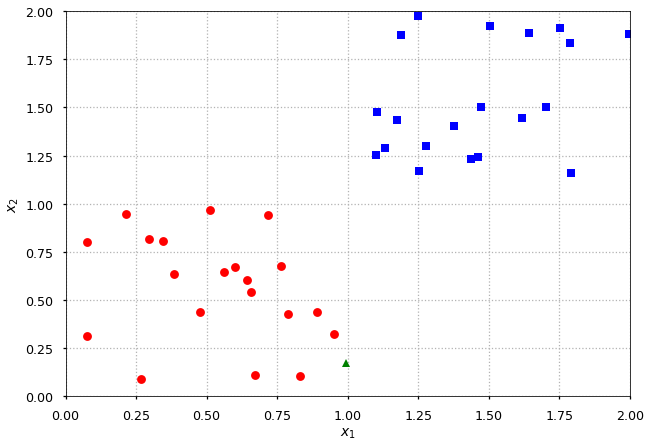

In [2]:
X1 = generate_random_points(20, 0, 1)
X2 = generate_random_points(20, 1, 2)

new_point = generate_random_points(1, 0, 2)

plot = init_plot([0, 2], [0, 2])  # [0, 2] x [0, 2]

plot.plot(*X1.T, 'ro', *X2.T, 'bs', *new_point.T, 'g^');

## Nearest Neighbor

* The nearest neigbor classifier *compares* a test sample with all training samples to predict a label (class).

* How to compare two samples?

    * L1 distance: $d(\vec x_1, \vec x_2) = \sum\limits_i |x_1^i - x_2^i|$

    * L2 distance: $d(\vec x_1, \vec x_2) = \sqrt{\sum\limits_i (x_1^i - x_2^i)^2}$
    
        * note: in practice square root is ignored (becasue is monotonic function)
        
        * L2 is less forgiving than L1 - prefers many small disagreements than one big one
  
    * cosine distance (cosine similarity): $d(\vec x_1, \vec x_2) = \frac{x_1 \cdot x_1}{||\vec x_1|| \cdot ||\vec x_2||}$

    * Chebyshev distance: $d(\vec x_1, \vec x_2) = max_i(|x_1^i - x_2^i|)$
    
    * and many others
    
* The closest one determines the test sample label

### Implementation

* The implementation of nearest neighbor algorithm is pretty straightforward

* There is no real training process here - we just need to remember all training feature vectors and corresponding labels

* To predict a label for new sample we just need to find the label of the closest point from training samples

In [0]:
class NearestNeighbor():
  """Nearest Neighbor Classifier"""
  
  def __init__(self, distance=0):
    """Set distance definition: 0 - L1, 1 - L2"""
    if distance == 0:
      self.distance = np.abs     # absolute value
    elif distance == 1:
      self.distance = np.square  # square root
    else:
      raise Exception("Distance not defined.")
    
  
  def train(self, x, y):
    """Train the classifier (here simply save training data)
    
    x -- feature vectors (N x D)
    y -- labels (N x 1)
    """
    self.x_train = x
    self.y_train = y
    

  def predict(self, x):
    """Predict and return labels for each feature vector from x
    
    x -- feature vectors (N x D)
    """
    predictions = []  # placeholder for N labels
    
    # loop over all test samples
    for x_test in x:
      # array of distances between current test and all training samples
      distances = np.sum(self.distance(self.x_train - x_test), axis=1)
      
      # get the closest one
      min_index = np.argmin(distances)
      
      # add corresponding label
      predictions.append(self.y_train[min_index])

    return predictions

### The magic of numpy

* NumPy is irreplacable tool for numerical operations on arrays

* Using numpy we could easily find all distances using one line

```
distances = np.sum(self.distance(self.x_train - x_test), axis=1)

```

* Here is how it works

In [4]:
# let's create an array with 5x2 shape
a = np.random.random_sample((5, 2))

# and another array with 1x2 shape
b = np.array([[1., 1.]])

print(a, b, sep="\n\n")

[[0.79036457 0.36571819]
 [0.76743991 0.08439684]
 [0.56876884 0.97967839]
 [0.77020776 0.21238365]
 [0.94235534 0.73884472]]

[[1. 1.]]


In [5]:
# subtract arguments (element-wise)
# note, that at least one dimension must be the same 
print(a - b)

[[-0.20963543 -0.63428181]
 [-0.23256009 -0.91560316]
 [-0.43123116 -0.02032161]
 [-0.22979224 -0.78761635]
 [-0.05764466 -0.26115528]]


In [6]:
# numpy.abs calculates absolute value (element-wise)
print(np.abs(a - b))

[[0.20963543 0.63428181]
 [0.23256009 0.91560316]
 [0.43123116 0.02032161]
 [0.22979224 0.78761635]
 [0.05764466 0.26115528]]


In [7]:
# sum all elements
np.sum(np.abs(a - b))

3.7798417848539096

In [8]:
# sum elements over a given axis
np.sum(np.abs(a - b), axis=0)

array([1.16086358, 2.61897821])

In [9]:
np.sum(np.abs(a - b), axis=1)

array([0.84391724, 1.14816326, 0.45155276, 1.01740859, 0.31879994])

### Analysis

* Before we start using `NearestNeighbor` let's create a simple mini-framework to apply NN and visualize results easily

* We want to initilize `NearestNeighbor` with some feature vectors (and automatically assign labels for each class)

* We want our test samples to be a grid of uniformly distributed points

* We want methods to process test data and to make a plots with final results

In [0]:
class Analysis():
  """Apply NearestNeighbor to generated (uniformly) test samples."""
  
  def __init__(self, *x, distance):
    """Generate labels and initilize classifier
    
    x -- feature vectors arrays
    distance -- 0 for L1, 1 for L2    
    """
    # get number of classes
    self.nof_classes = len(x)
    
    # create lables array
    # np.ones creates an array of given shape filled with 1 of given type
    # we apply consecutive integer numbers as class labels
    # ravel return flatten array
    y = [i * np.ones(_x.shape[0], dtype=np.int) for i, _x in enumerate(x)]
    y = np.array(y).ravel()

    # save training samples to plot them later
    self.x_train = x
    
    # merge feature vector arrays for NearestNeighbor
    x = np.concatenate(x, axis=0)
    
    # train classifier
    self.nn = NearestNeighbor(distance)
    self.nn.train(x, y)
        
    
  def prepare_test_samples(self, low=0, high=2, step=0.01):
    """Generate a grid with test points (from low to high with step)"""
    # remember range
    self.range = [low, high]
    
    # start with grid of points from [low, high] x [low, high]
    grid = np.mgrid[low:high+step:step, low:high+step:step]
    
    # convert to an array of 2D points
    self.x_test = np.vstack([grid[0].ravel(), grid[1].ravel()]).T
    
  
  def analyse(self):
    """Run classifier on test samples and split them according to labels."""
    
    # find labels for test samples 
    self.y_test = self.nn.predict(self.x_test)
    
    self.classified = []  # [class I test points, class II test ...]
    
    # loop over available labels
    for label in range(self.nof_classes):
      # if i-th label == current label -> add test[i]
      class_i = np.array([self.x_test[i] \
                          for i, l in enumerate(self.y_test) \
                          if l == label])
      self.classified.append(class_i)
  
  
  def plot(self, t=''):
    """Visualize the result of classification"""
    plot = init_plot(self.range, self.range)
    plot.set_title(t)
    plot.grid(False)
    
    # plot training samples
    for i, x in enumerate(self.x_train):
      plot.plot(*x.T, mpl_colors[i] + 'o')
      
    # plot test samples
    for i, x in enumerate(self.classified):
      plot.plot(*x.T, mpl_colors[i] + ',')

### L1 test

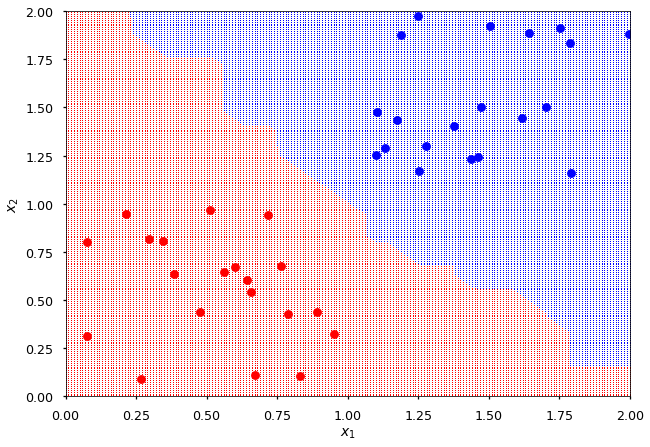

In [11]:
l1 = Analysis(X1, X2, distance=0)
l1.prepare_test_samples()
l1.analyse()
l1.plot()

### L2 Test

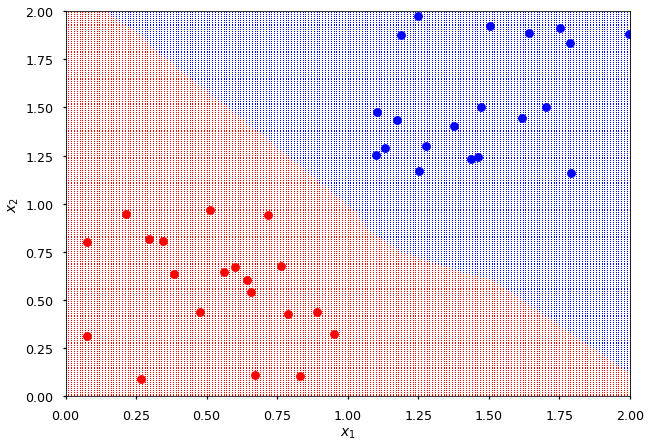

In [12]:
l2 = Analysis(X1, X2, distance=1)
l2.prepare_test_samples()
l2.analyse()
l2.plot()

### Multiclass classification

* Training samples from 4 squares:

    * [0, 1] x [0, 1]
    * [0, 1] x [1, 2]
    * [1, 2] x [0, 1]
    * [1, 2] x [1, 2]
    
* We expect 4 squares created by test samples grid

* How does it depend on the size of training samples?

In [0]:
def generate4(n=50):
  """Generate 4 sets of random points."""
  
  # points from [0, 1] x [0, 1]
  X1 = generate_random_points(n, 0, 1)
  # points from [1, 2] x [1, 2]
  X2 = generate_random_points(n, 1, 2)
  # points from [0, 1] x [1, 2]
  X3 = np.array([[x, y+1] for x,y in generate_random_points(n, 0, 1)])
  # points from [1, 2] x [0, 1]
  X4 = np.array([[x, y-1] for x,y in generate_random_points(n, 1, 2)])

  return X1, X2, X3, X4

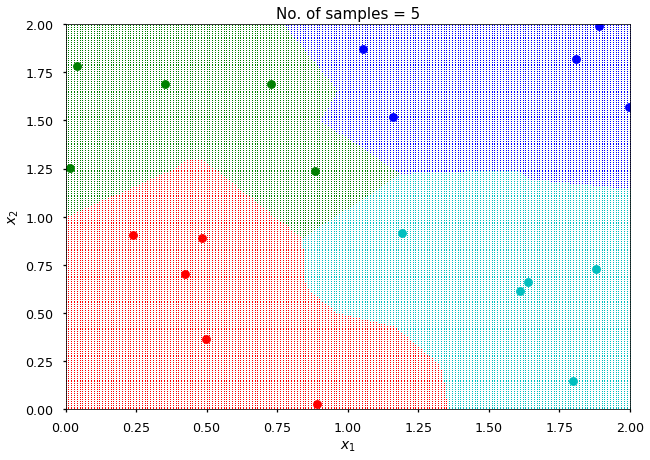

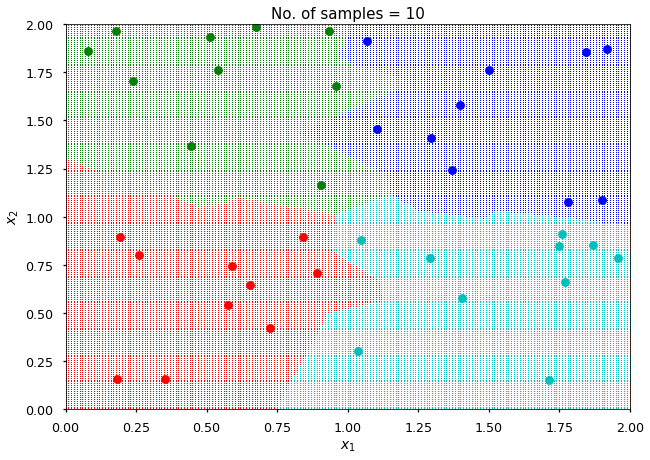

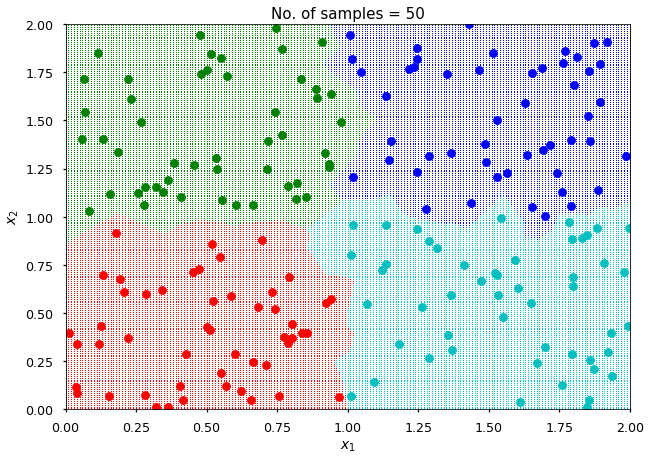

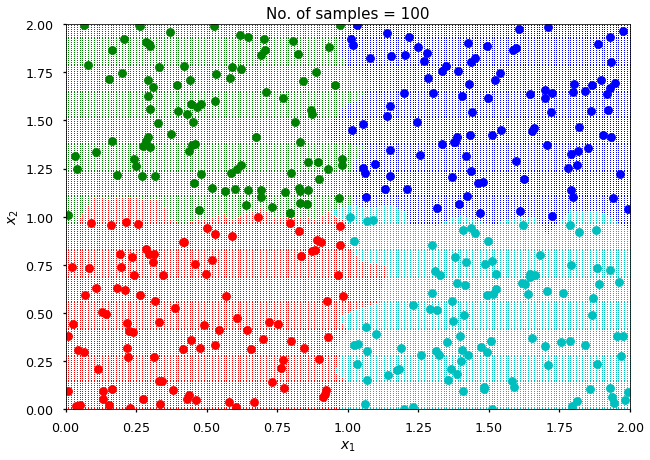

In [14]:
# loop over no. of training samples
for n in (5, 10, 50, 100):
  # generate 4 sets of random points (each one with n samples)
  # unpack them when passing to Analysis
  c4 = Analysis(*generate4(n), distance=1)
  c4.prepare_test_samples()
  c4.analyse()
  c4.plot("No. of samples = {}".format(n))

<font color=red size=5>Message 01: size matters!</font>

### Noise


* Data are rarely perfect and you may expect some training samples to have unsual features

* Features shared by a majority of training samples are more important than a single occurrence

* Let's add some noise to our data and see how Nearest Neighbor deal with it

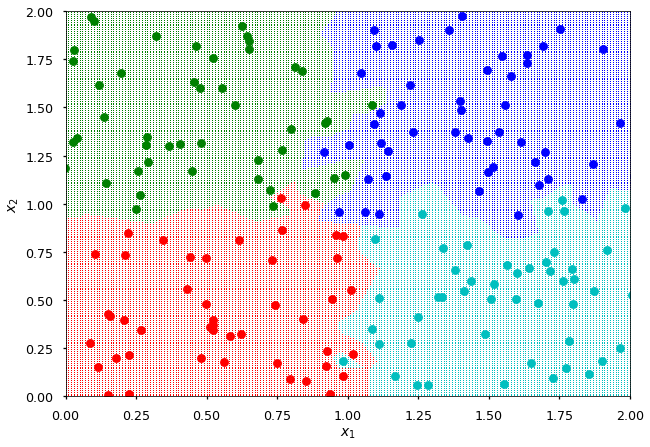

In [15]:
# generate 4 classes of 2D points
X1, X2, X3, X4 = generate4()

# add some noise by applying gaussian to every point coordinates
noise = lambda x, y: [np.random.normal(x, 0.1), np.random.normal(y, 0.1)]

X1 = np.array([noise(x, y) for x, y in X1])
X2 = np.array([noise(x, y) for x, y in X2])
X3 = np.array([noise(x, y) for x, y in X3])
X4 = np.array([noise(x, y) for x, y in X4])

# perform analysis
c4 = Analysis(X1, X2, X3, X4, distance=1)
c4.prepare_test_samples()
c4.analyse()
c4.plot()

### Overfitting

* The above is an example of overfitting

    * perfectly describe training data
    * lose the generalization ability

* In general you want to extract all common features from training samples, but neglect characteristic features of single sample
  
<font color=red size=5>Message 02: avoid overfitting!</font>

### Accuracy

* Accuracy defines the fraction of (unseen) samples which are correctly classify by the algorithm 

In [16]:
accuracy = 0

# loop over (sample, reconstructed label)
for sample, label in zip(c4.x_test, c4.y_test):
  # determine true label
  if sample[0] < 1 and sample[1] < 1:
    true_label = 0
  elif sample[0] > 1 and sample[1] > 1:
    true_label = 1
  elif sample[0] < 1 and sample[1] > 1:
    true_label = 2
  else:
    true_label = 3
    
  if true_label == label: accuracy += 1
    
accuracy /= len(c4.x_test)

print(accuracy)

0.924878097076805


* Please note, that this is a toy model - in the case of real problems there is no way to determine true labels (otherwise there is no point to use ML methods...)

* To measure accuracy of the model one usually splits data into:

    * training samples (usually about 80%)

    * test samples (usually about 20%)
  
* After the model is trained on training samples, the accuracy is measured on test samples

<font color=red size=5>Message 03: keep some data for testing!</font>

## k-Nearest Neighbors

* Instead of letting one closest neighbor to decide, let *k* nearest neghbors to vote

### Implementation

* We can base the implementation on `NearestNeighbor`, but

* The *constructor* has an extra parameter *k*

* and we need to override `predict` method

In [0]:
class kNearestNeighbors(NearestNeighbor):
  """k-Nearest Neighbor Classifier"""
  
  
  def __init__(self, k=1, distance=0):
    """Set distance definition: 0 - L1, 1 - L2"""
    super().__init__(distance)
    self.k = k
    
  
  def predict(self, x):
    """Predict and return labels for each feature vector from x
    
    x -- feature vectors (N x D)
    """
    predictions = []  # placeholder for N labels
    
    # no. of classes = max label (labels starts from 0)
    nof_classes = np.amax(self.y_train) + 1
    
    # loop over all test samples
    for x_test in x:
      # array of distances between current test and all training samples
      distances = np.sum(self.distance(self.x_train - x_test), axis=1)
      
      # placeholder for labels votes
      votes = np.zeros(nof_classes, dtype=np.int)
            
      # find k closet neighbors and vote
      # argsort returns the indices that would sort an array
      # so indices of nearest neighbors
      # we take self.k first
      for neighbor_id in np.argsort(distances)[:self.k]:
        # this is a label corresponding to one of the closest neighbor
        neighbor_label = self.y_train[neighbor_id]
        # which updates votes array
        votes[neighbor_label] += 1
                
      # predicted label is the one with most votes
      predictions.append(np.argmax(votes))

    return predictions

### kAnalysis

* We also create `kAnalysis` based on `Analysis` for visualization of kNN results

In [0]:
class kAnalysis(Analysis):
  """Apply kNearestNeighbor to generated (uniformly) test samples."""
  
  def __init__(self, *x, k=1, distance=1):
    """Generate labels and initilize classifier
    
    x -- feature vectors arrays
    k -- number of nearest neighbors
    distance -- 0 for L1, 1 for L2    
    """
    # get number of classes
    self.nof_classes = len(x)
    
    # create lables array
    y = [i * np.ones(_x.shape[0], dtype=np.int) for i, _x in enumerate(x)]
    y = np.array(y).ravel()

    # save training samples to plot them later
    self.x_train = x
    
    # merge feature vector arrays for NearestNeighbor
    x = np.concatenate(x, axis=0)
    
    # train classifier (knn this time)
    self.nn = kNearestNeighbors(k, distance)
    self.nn.train(x, y)

### Sanity check

* k-Nearest Neighbor classifier with *k = 1* must give exactly the same results as Nearest Neighbor

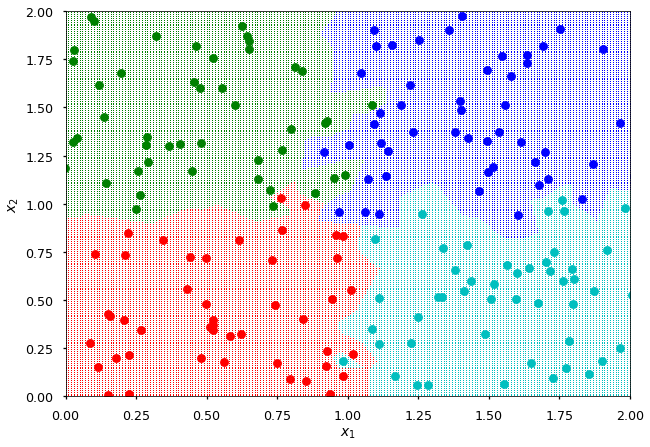

In [19]:
# apply kNN with k=1 on the same set of training samples
knn = kAnalysis(X1, X2, X3, X4, k=1, distance=1)
knn.prepare_test_samples()
knn.analyse()
knn.plot()

### k-Test

* For *k = 1* kNN is likely to overfit the problem

* Although, it does not mean that higher *k* is better!

* Now, let's see how different values of *k* affects the result

* Later, we will learn how to find optimal value of *k* for given problem

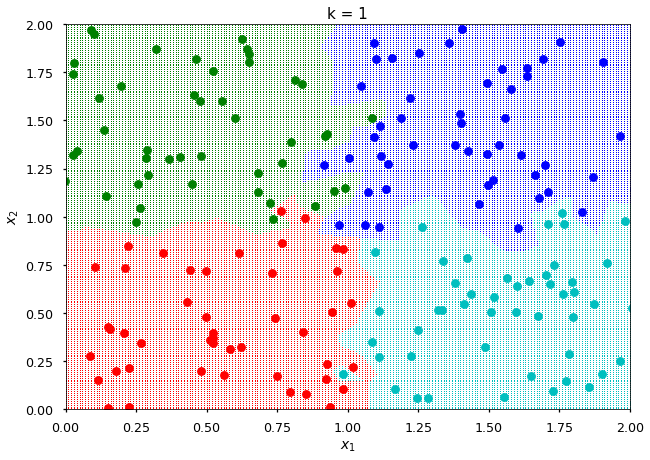

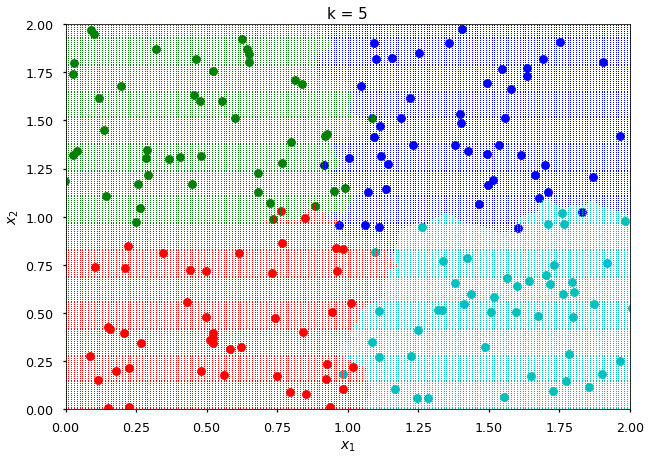

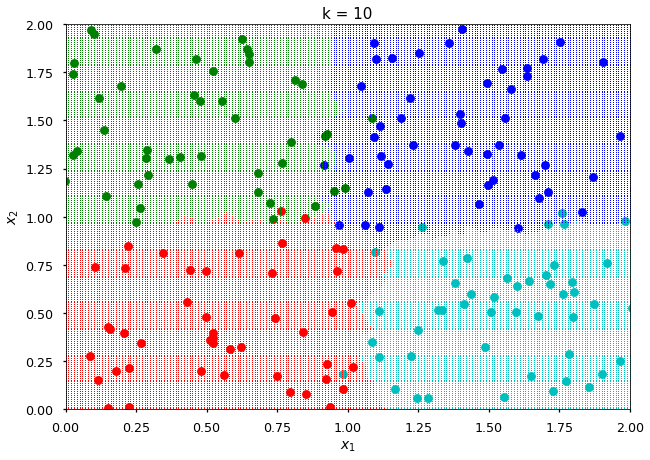

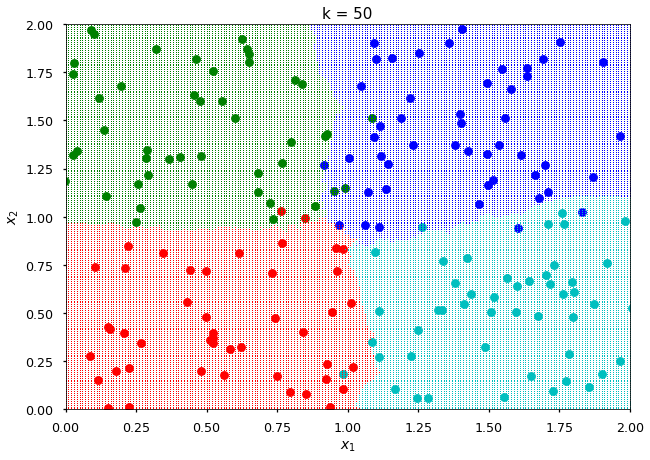

In [20]:
# training size = 50
# let's check a few values between 1 and 50
for k in (1, 5, 10, 50):
  knn = kAnalysis(X1, X2, X3, X4, k=k, distance=1)
  knn.prepare_test_samples()
  knn.analyse()
  knn.plot("k = {}".format(k))

## Hyperparameters

* ML model may have some hyperparameters - parameters set before training

* Please note, ML algorithm may have also parameters which are set during training

* In the case of kNN there are two hyperparameters:

    * number of nearest neihgbors (*k*)

    * the definition of distance

* The choice of hyperparameters values highly depends on a problem

* The wrong choice of hyperparameters may lead to underfitting or overfitting

### Over-, under-fitting example

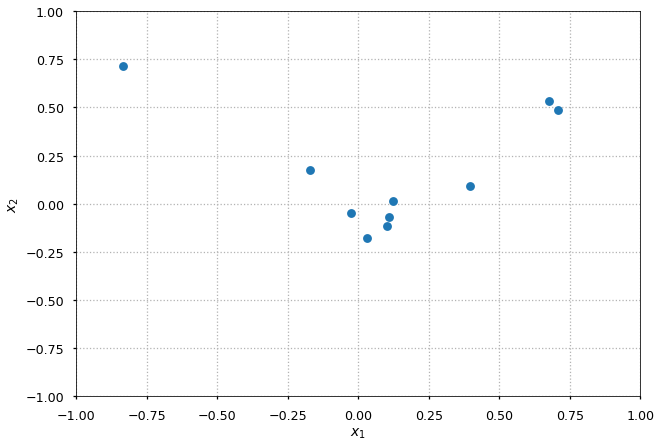

In [21]:
# generate random data from x^2 function (with some noise)
data = np.array([[x, np.random.normal(x**2, 0.1)] \
                 for x in 2*np.random.random(10) - 1])

plot = init_plot([-1, 1], [-1, 1])
plot.plot(*data.T, 'o');

* Let's try to fit this data to a polynomial

* The degree is a hyperparamter (which defines number of coefficients)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


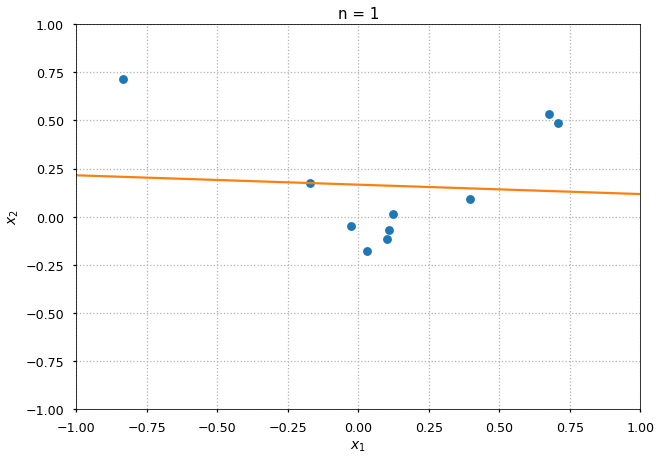

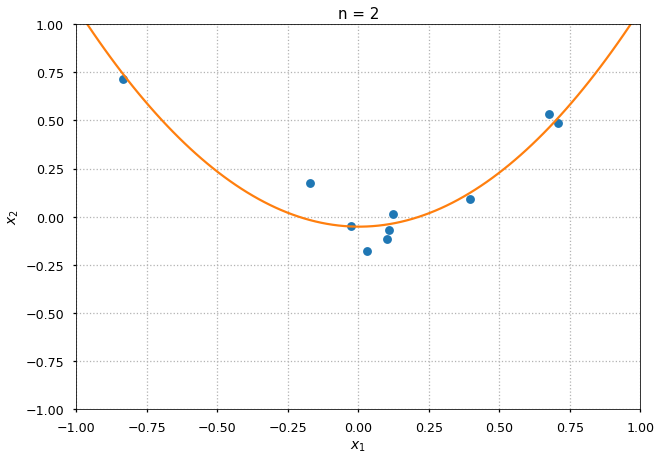

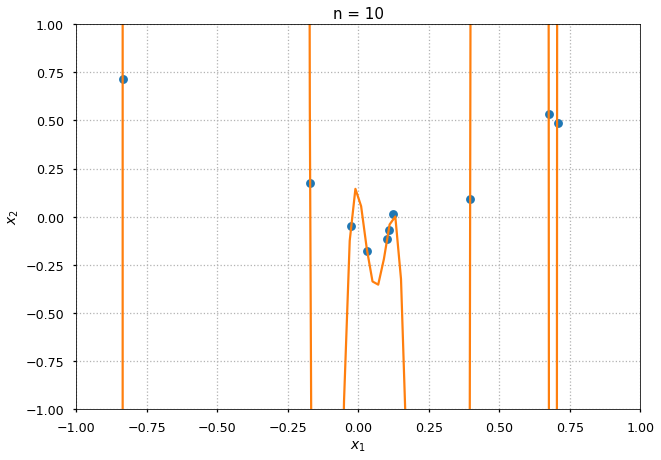

In [22]:
# loop over degrees of polynomial
# data is x^2, so let's try degrees 1, 2, 10
for n in (1, 2, 10):
  # polyfit returns an array with polynomial coefficients
  # poly1d is a polynomial class
  f = np.poly1d(np.polyfit(*data.T, n))
  
  # returns an array with 100 uniformly distributed numbers from -1 to 1
  x = np.linspace(-1, 1, 100)

  plot = init_plot([-1, 1], [-1, 1])
  plot.set_title("n = {}".format(n))
  plot.plot(*data.T, 'o', x, f(x))

* For *n = 1* we clearly underfit the data as we do not have enough parameters to describe the complexity of the problem

* For *n = 2* we have appropriate capacity (as we actually generated data form $x^2$ function)

* For *n = 10* we overfit the data - training samples are described perfectly, but we clearly lost the generalization ability

<font color=red size=5>Message 04: right choice of hyperparameters is crucial!</font>

### Validation dataset

* One splits data into training and test samples

    * training samples are used to optimize model parameters
    
    * test samples are used to measure accuracy
    
    * there is no rule of thumb on how to split dataset

* If a model has some hyperparameters the part of training set is used for valitation samples:

    * training samples - tuning model parameters
    
    * validation samples - tuning hyperparameters
  
```
                  +---------------------+      +------------------------+
+----------+      |                     |      |                        |
|          |      | Measure accuracy on |      | Measure final accuracy |
| Training | +--> |                     | +--> |                        |
|          |      | validation samples  |      | on test samples        |
+----------+      |                     |      |                        |
     ^            +----------+----------+      +------------------------+
     |                       |
     |      Change           | 
     +-----------------------+
         hyperparameters
```

## Iris dataset

* The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant. One class is linearly separable from the other 2; the latter are NOT linearly separable from each other. [src](https://archive.ics.uci.edu/ml/datasets/iris)

* Attribute Information:

    * sepal length in cm
    
    * sepal width in cm
    
    * petal length in cm
    
    * petal width in cm
    
    * class: 

        * Iris Setosa
        
        * Iris Versicolour
        
        * Iris Virginica

### Load dataset

* We use `pandas` for data manipulation - it is super handy and supports many formats

In [0]:
import pandas as pd

# columns names - can be used to access columns later
columns = ["Sepal Length", "Sepal Width",
           "Petal Length", "Petal Width",
           "Class"]

# iris.data is a csv file
src = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

# load the file with pandas.read_csv 
# it will name columns as defined in columns list
# so one can access a column through index or name
iris_data = pd.read_csv(src, header=None, names=columns)

In [24]:
iris_data.head()  # print a few first entries

,Sepal Length,Sepal Width,Petal Length,Petal Width,Class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


### Visualize dataset

* `pandas` offers plotting through `matplotlib` integration

* Let's visualize Iris data

* Let's keep the code short - sorry if it is hard to follow

In [0]:
# to extract rows with class column == class_name
extract = lambda class_name: iris_data.loc[iris_data['Class'] == class_name]

# axes settings - part = Sepal or Petal; x = Length, y = Width
set_ax = lambda part: {"x": part + " Length",
                       "y": part + " Width",
                       "kind": "scatter"}

# add iris type / sepal or petal / color to existing axis
plot = lambda class_name, part, color, axis: \
  extract(class_name).plot(**set_ax(part),
                           color=color,
                           label=class_name,
                           ax=axis)
  
# plot all Iris types (sepal or petal) on existing axis
plot_all = lambda part, axis: \
  [plot(iris, part, mpl_colors[i], axis) \
   for i, iris in enumerate(set(iris_data['Class']))] 

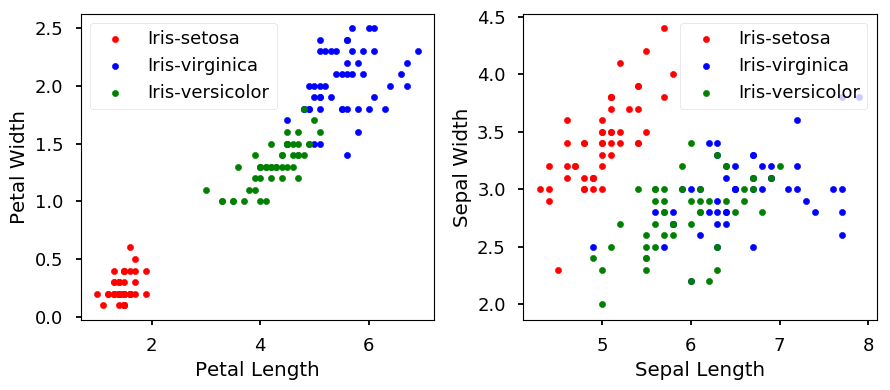

In [26]:
# with pyplot.subplots we can create many plots on one figure
# here we create 2 plots - 1 row and 2 columns
# thus, subplots returns figure, axes of 1st plot, axes for 2nd plot
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))

# using messy lambda we can plot all Iris types at once
# Petal data on 1st plots and Sepal data on 2nd plot
plot_all("Petal", ax1)
plot_all("Sepal", ax2)

# tight_layout adjust subplots params so they fit into figure ares
plt.tight_layout()

### Prepare feature vectors and labels

* First step is to prepare data - we need feature vectors with corresponding labels

* In this case every sample's feature vector is 4D (sepal length, sepal width, petal length, petal width) and is labeled with one of three classes (Iris Setosa, Iris Versicolour, Iris Virginica)

In [27]:
# every Iris has 4 features (forming our 4D feature vectors)
# pandaoc.DataFrame.iloc allows us access data through indices
# we create an array with feature vectors by taking all rows for first 4 columns
X = iris_data.iloc[:, :4]

# it is still pandoc.DataFrame object - pretty handy
X.head()

,Sepal Length,Sepal Width,Petal Length,Petal Width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


* `pandas.DataFrame` object are handy to manipulate data, but at the end of the day we want to perform algebra with `numpy`

In [28]:
# create numpy array (matrix) for further processing
X = np.array(X)

# print a few first entries
print(X[:5])

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]


* from the las column ("Class") we create our labels

In [29]:
# as mentioned before, we can access DataFrame object through column labels
Y = np.array(iris_data["Class"])

# print a few first entries
print(Y[:5])

['Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa']


### Prepare test dataset

* Let's use 80% for training and 20% for testing

* We, obviously, can not just take last 20% of samples for testing because our data is ordered

* But we can randomly select 20% of samples

* Easy to do by hand, but let's start to use some ML frameworks

In [30]:
from sklearn.model_selection import train_test_split as split

# train_test_split: Split arrays or matrices into random train and test subsets
X_train, X_test, Y_train, Y_test = split(X, Y, test_size=0.2)

# let's use 20% of training samples for validation
X_train, X_valid, Y_train, Y_valid = split(X_train, Y_train, test_size=0.2)

# check how many sample we have
print(X_train.shape[0], X_valid.shape[0], X_test.shape[0])

96 24 30


### kNN from scikit-learn

* `scikit-learn` has already implemented k-Nearest Neighbor algorithm (which is more flexible than the one implemented during this lecture)

* Let's see how *complicated* is using one of ML frameworks with Python

In [0]:
from sklearn.neighbors import KNeighborsClassifier

# create knn classifier with k = 48
knn = KNeighborsClassifier(n_neighbors=48)

# train the model
knn.fit(X_train, Y_train)

# predict labels for test samples
Y_pred = knn.predict(X_valid)

### Accuracy

* First let's print true labels along with predicted ones

In [32]:
# use bold if true != predicted
for true, pred in zip(Y_valid, Y_pred):
  if pred == true:
    print("{}\t -> {}".format(true, pred))
  else:
    print("\033[1m{}\t -> {}\033[0m".format(true, pred))

Iris-setosa	 -> Iris-setosa
Iris-versicolor	 -> Iris-versicolor
Iris-setosa	 -> Iris-setosa
Iris-versicolor	 -> Iris-versicolor
Iris-virginica	 -> Iris-virginica
Iris-virginica	 -> Iris-virginica
Iris-versicolor	 -> Iris-virginica
Iris-virginica	 -> Iris-virginica
Iris-versicolor	 -> Iris-versicolor
Iris-setosa	 -> Iris-setosa
Iris-virginica	 -> Iris-virginica
Iris-versicolor	 -> Iris-versicolor
Iris-virginica	 -> Iris-virginica
Iris-virginica	 -> Iris-versicolor
Iris-virginica	 -> Iris-virginica
Iris-virginica	 -> Iris-virginica
Iris-versicolor	 -> Iris-versicolor
Iris-setosa	 -> Iris-setosa
Iris-setosa	 -> Iris-setosa
Iris-virginica	 -> Iris-virginica
Iris-virginica	 -> Iris-versicolor
Iris-setosa	 -> Iris-setosa
Iris-versicolor	 -> Iris-versicolor
Iris-virginica	 -> Iris-versicolor


* We can easily calculate accuracy by hand as it is just a number of correctly predicted labels divided by no. of samples

In [33]:
# Y_valid == Y_pred -> array of True/False (if two elements are equal or not)
# (Y_valid == Y_pred).sum() -> number of Trues
# Y_valid.shape[0] -> number of validation samples
accuracy = (Y_valid == Y_pred).sum() / Y_valid.shape[0]

print(accuracy)

0.8333333333333334


* But we can also use `scikit-learn` function `accuracy_score`

In [34]:
from sklearn.metrics import accuracy_score

print(accuracy_score(Y_valid, Y_pred))

0.8333333333333334


### k-dependence of the accuracy

* Let's use validation set to determine the best hyperparameter *k*

* We will run kNN for various values of *k* and measure accuracy

* This will allow us to find the optimal value of *k*

* And check the accuracy on the test dataset

In [0]:
scores = []  # placeholder for accuracy

max_k = 85  # maximum number of voters

# loop over different values of k
for k in range(1, max_k):
  # create knn classifier with k = k
  knn = KNeighborsClassifier(n_neighbors=k)

  # train the model
  knn.fit(X_train, Y_train)

  # predict labels for test samples
  Y_pred = knn.predict(X_valid)
  
  # add accuracy to score table
  scores.append(accuracy_score(Y_valid, Y_pred))

* Now, we can plot accuracy as a function of *k*

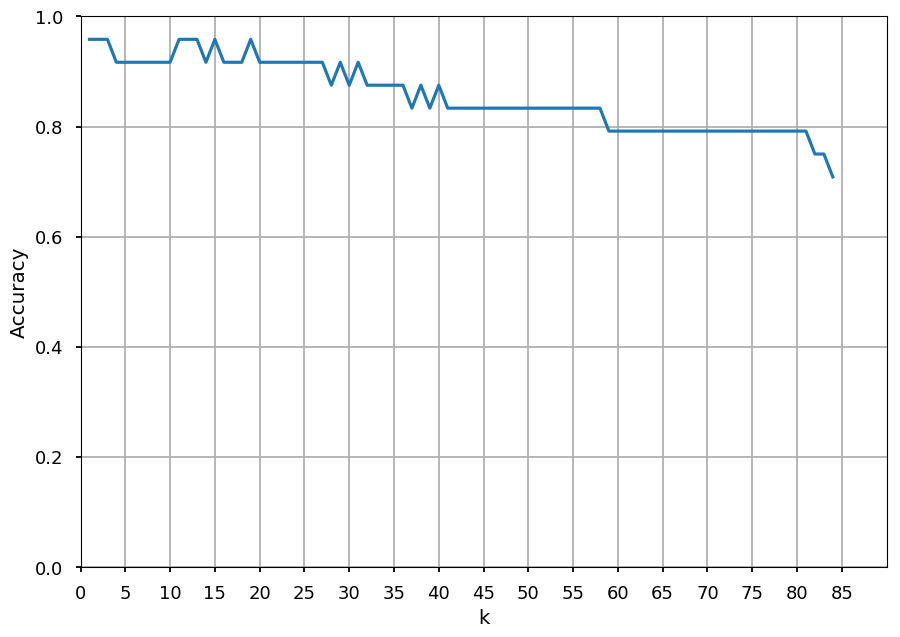

In [36]:
def k_accuracy_plot(max_k=85):
  """Just plot settings"""
  plt.grid(True)
  plt.xlabel("k")
  plt.ylabel("Accuracy")
  plt.xlim([0, max_k + 5])
  plt.ylim([0, 1])
  plt.xticks(range(0, max_k + 5, 5))
  
  return plt

k_accuracy_plot().plot(range(1, max_k), scores);

* And check the accuracy measured on the test samples

In [37]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
  
print(accuracy_score(Y_test, Y_pred))

0.9666666666666667


* The accuracy plot is not smooth

* It is common if one does not have enough validation samples

* But there is another way to measure accuracy dependence on hyperparameters

### Cross-validation

```
         Split training samples into N folds

 +-------+   +-------+   +-------+         +-------+
 |       |   |       |   |       |         |       |
 |   1   |   |   2   |   |   3   |   ...   |   N   |
 |       |   |       |   |       |         |       |
 +-------+   +-------+   +-------+         +-------+

Take one fold as validation set and train on N-1 folds

 +-------+   +-------+   +-------+         +-------+
 |*******|   |       |   |       |         |       |
 |*******|   |   2   |   |   3   |   ...   |   N   |
 |*******|   |       |   |       |         |       |
 +-------+   +-------+   +-------+         +-------+

         Take the next one as validation set

 +-------+   +-------+   +-------+         +-------+
 |       |   |*******|   |       |         |       |
 |   1   |   |*******|   |   3   |   ...   |   N   |
 |       |   |*******|   |       |         |       |
 +-------+   +-------+   +-------+         +-------+

          Repeat the procedure for all folds

 +-------+   +-------+   +-------+         +-------+
 |       |   |       |   |       |         |*******|
 |   1   |   |   2   |   |   3   |   ...   |*******|
 |       |   |       |   |       |         |*******|
 +-------+   +-------+   +-------+         +-------+

            And average out the accuracy
```

* Once again `scikit-learn` has already implemented the procedure we need

In [0]:
from sklearn.model_selection import cross_val_score

# this time we do not create dedicated validation set
X_train, X_test, Y_train, Y_test = split(X, Y, test_size=0.2)

avg_scores = []  # average score for different k

nof_folds = 10

# loop over different values of k
for k in range(1, max_k):
  # create knn classifier with k = k
  knn = KNeighborsClassifier(n_neighbors=k)

  # cross-validate knn on our training sample with nof_folds
  scores = cross_val_score(knn, X_train, Y_train,
                           cv=nof_folds, scoring='accuracy')
  
  # add avg accuracy to score table
  avg_scores.append(scores.mean())

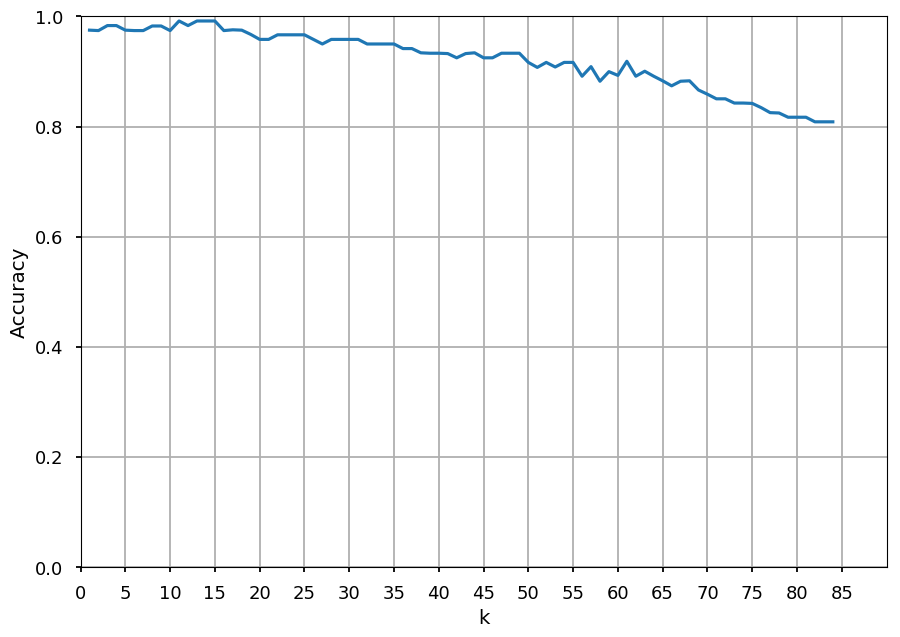

In [39]:
k_accuracy_plot().plot(range(1, max_k), avg_scores);

* In theory, k-fold cross-validation is the way to go (especially if a dataset is small)

* In practice, people tend to use a single validation split as it is not that computational expensive

### Data normalization

* Sometimes there is a need to preprocess data before training

* Let's imagine Iris sepal data is in cm but petal data in mm

In [40]:
# original data - both in cm
print(X[:5])

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]


In [41]:
# make a copy of X
Xmm = X.copy()

# and multiply last two columns by 0.1
Xmm[:,2:] *= 0.1

# and we have our fake Iris data with petal length/width in mm
print(Xmm[:5])

[[5.1  3.5  0.14 0.02]
 [4.9  3.   0.14 0.02]
 [4.7  3.2  0.13 0.02]
 [4.6  3.1  0.15 0.02]
 [5.   3.6  0.14 0.02]]


* Let's compare result of the same classifier on both dataset

In [42]:
def get_accuracy(X, Y, k=10):
  """Make training and test datasets and process through kNN"""
  
  # prepare training / test samples
  X_train, X_test, Y_train, Y_test = split(X, Y, test_size=0.2)

  # create a kNN with k = k
  knn = KNeighborsClassifier(n_neighbors=k)

  # get prediction for original dataset
  knn.fit(X_train, Y_train)
  Y_pred = knn.predict(X_test)
  
  return accuracy_score(Y_test, Y_pred)

cm = get_accuracy(X, Y)
mm = get_accuracy(Xmm, Y)

print("Accuracy:\n\tboth in cm: {}\n\tpetal in mm: {}".format(cm, mm))

Accuracy:
	both in cm: 1.0
	petal in mm: 0.7


* It is kind of obvious here - petal information will barely contribute to the distance

* However, it is not always obvious if some features are not suppressed by the way data is normalized

<font color=red size=5>Message 05: be aware of data normalization!</font>

## MNIST

* [THE MNIST DATABASE of handwritten digits](http://yann.lecun.com/exdb/mnist/)

* *The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.*

* *It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting.*

---

* To make it simpler (and faster) let's use digits toy dataset which comes with `scikit-learn` [src](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html)

* Each datapoint is a 8x8 image of a digit.

* About 180 samples per class (digit)

* Total number of samples 1797

### Load digits

In [43]:
from sklearn.datasets import load_digits

digits = load_digits()

print(digits.data.shape)

(1797, 64)


* `digits.images` is a `numpy` array with 1797 `numpy` arrays 8x8 (feature vectors) representing digits

* `digits.target` is a `numpy` array with 1797 integer numbers (class labels)

* the code below allow us to visualize a random digits from the dataset

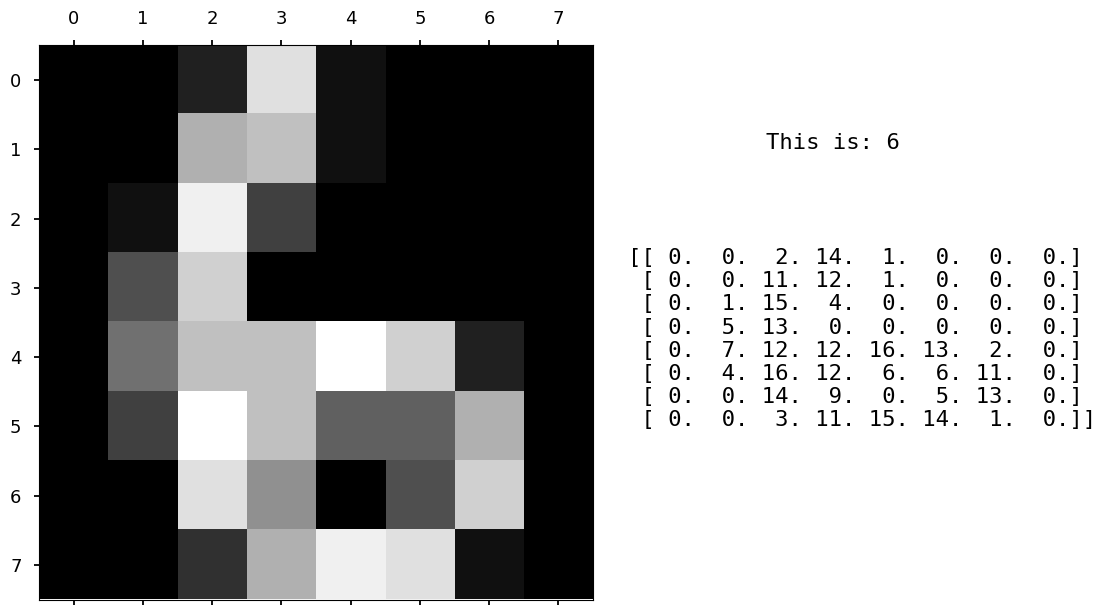

In [45]:
# set grayscale
plt.gray()

# get some random index from 0 to dataset size
random_index = np.random.randint(1796)


# draw random digit
plt.matshow(digits.images[random_index])

# and print the matrix
plt.text(8, 5, digits.images[random_index],
         fontdict={'family': 'monospace', 'size': 16})

# and the label
plt.text(10, 1, "This is: {}".format(digits.target[random_index]),
         fontdict={'family': 'monospace', 'size': 16});

### Distance between images

```
  TEST      TRAIN    PIXEL-WISE
| 4 2 0     2 5 8 |   |2 3 8|
| 5 3 9  -  2 8 1 | = |3 5 8|  ->  38
| 0 2 3     1 4 9 |   |1 2 6|
```

### Prepare data

* We need to split dataset to training and test samples

* However, images are in 8x8 format and we have to flatten them first

In [46]:
# the original shape of an image
print(digits.images.shape)

(1797, 8, 8)


In [47]:
# numpy.reshape is handy here
print(digits.images.reshape((1797, -1)).shape)

(1797, 64)


* Please note -1 in new shape

* `numpy.reshape` allows us to pass one *unknown* dimension which can be determined automatically

* Thus, the above is equivalent to

In [48]:
print(digits.images.reshape((1797, 64)).shape)

(1797, 64)


In [49]:
print(digits.images.reshape((-1, 64)).shape)

(1797, 64)


* As before, we can split our dataset using `sklearn.model_selection.train_test_split`

In [0]:
data_train, data_test, label_train, label_test = \
  split(digits.images.reshape((1797, -1)), digits.target, test_size=0.2)

### Cross-validation

* We perform cross-validation on training samples to determine the best *k* (as for the Iris dataset)

In [0]:
avg_scores = []  # average score for different k

max_k = 50
nof_folds = 10

# loop over different values of k
for k in range(1, max_k):
  # create knn classifier with k = k
  knn = KNeighborsClassifier(n_neighbors=k)

  # cross-validate knn on our training sample with nof_folds
  scores = cross_val_score(knn, data_train, label_train,
                           cv=nof_folds, scoring='accuracy')
  
  # add avg accuracy to score table
  avg_scores.append(scores.mean())

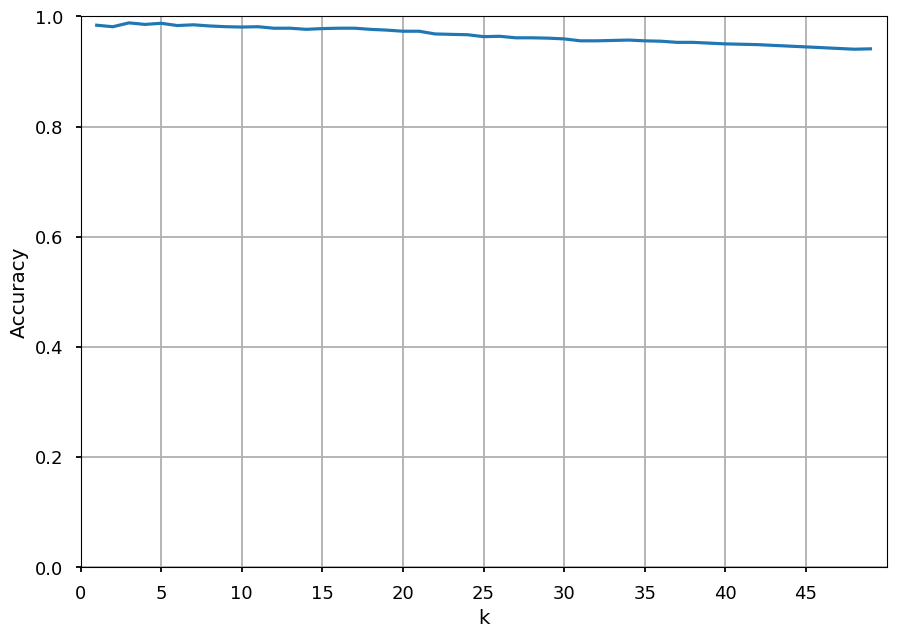

In [52]:
plt.grid(True)
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.xlim([0, max_k])
plt.ylim([0, 1])
plt.xticks(range(0, max_k, 5))
  
plt.plot(range(1, max_k), avg_scores);

* We used nearly the same procedure as for the Iris dataset

* Note, that digits toy dataset prefer different *k*

* This is the idea of ML - the same algorithm can solve different problems if train on different data

* Nowadays, in ML field **data is more important than algorithms** (we have good algorithms already) 

### Final test

* Let's take the bes *k* and check how the classifier works on test samples

In [53]:
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(data_train, label_train)
prediction = knn.predict(data_test)

print(accuracy_score(label_test, prediction))

0.9888888888888889


* We can take a look at misclassified digits

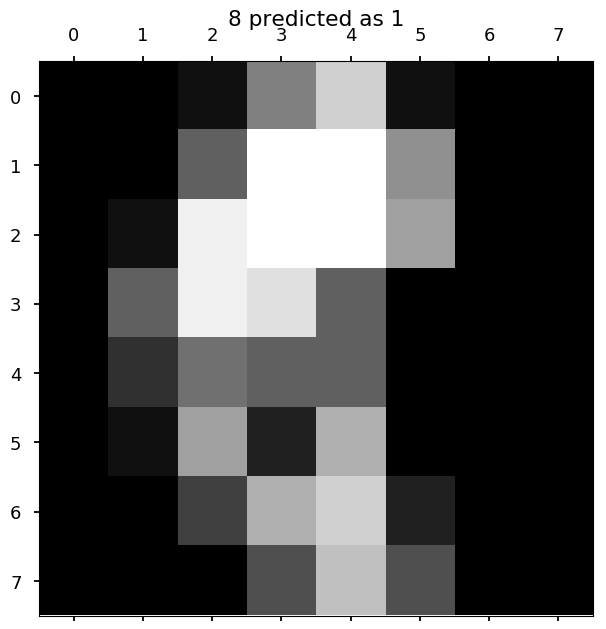

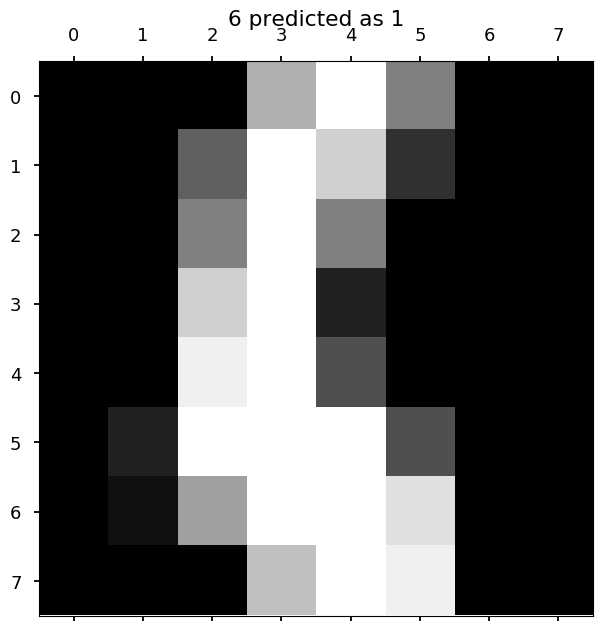

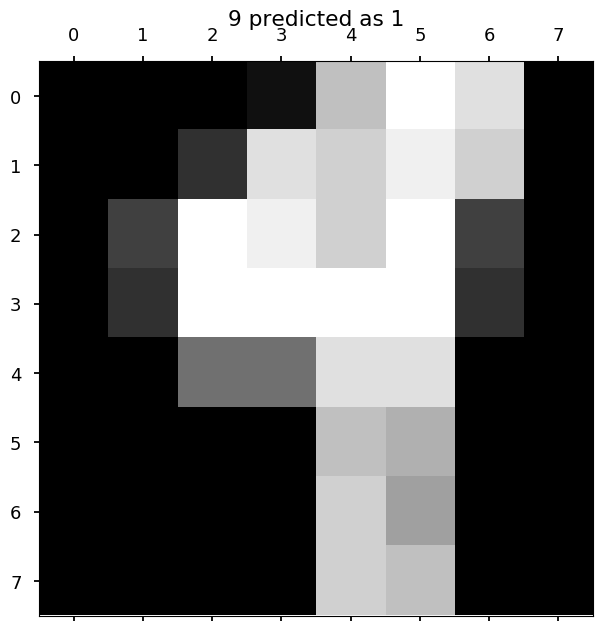

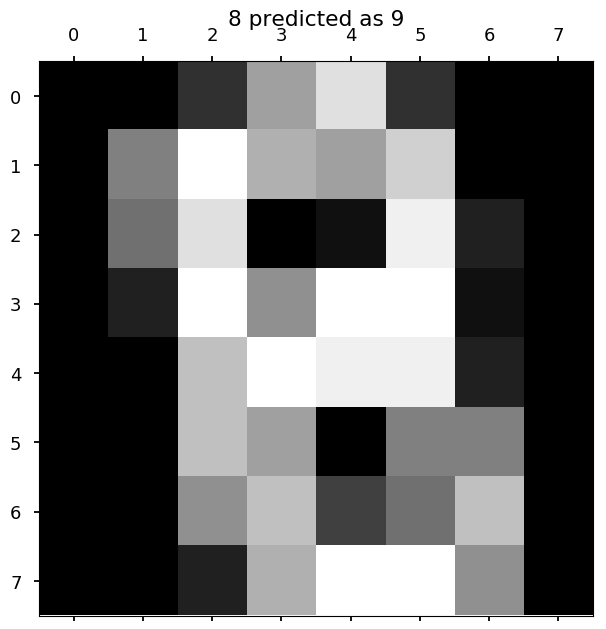

In [54]:
for i, (true, predict) in enumerate(zip(label_test, prediction)):
  if true != predict:
    digit = data_test[i].reshape((8, 8))  # reshape again to 8x8
    plt.matshow(digit)                    # for matshow
    plt.title("{} predicted as {}".format(true, predict))

## Regression with kNN

* It is also possible to do regression using k-Nearest Neighbors

    * find *k* nearest neighbors from training samples
    
    * calculate the predicted value using inverse distance weighting method
  
    $$y_{pred}(\vec x) = \frac{\sum\limits_i w_i(\vec x) y_{train, i}}{\sum\limits_i w_i(\vec x_i)}$$
  
    * where $w_i(\vec x) = \frac{1}{d(\vec x, \vec x_{train, i})}$
    
    * Note, that $y_{pred}(\vec x) = y_{train, i}$ if $d(\vec x, \vec x_{train, i}) = 0$

### Genearate some fake data

* Let's grab some random points from the sine function

* And add some noise to make it more like real data

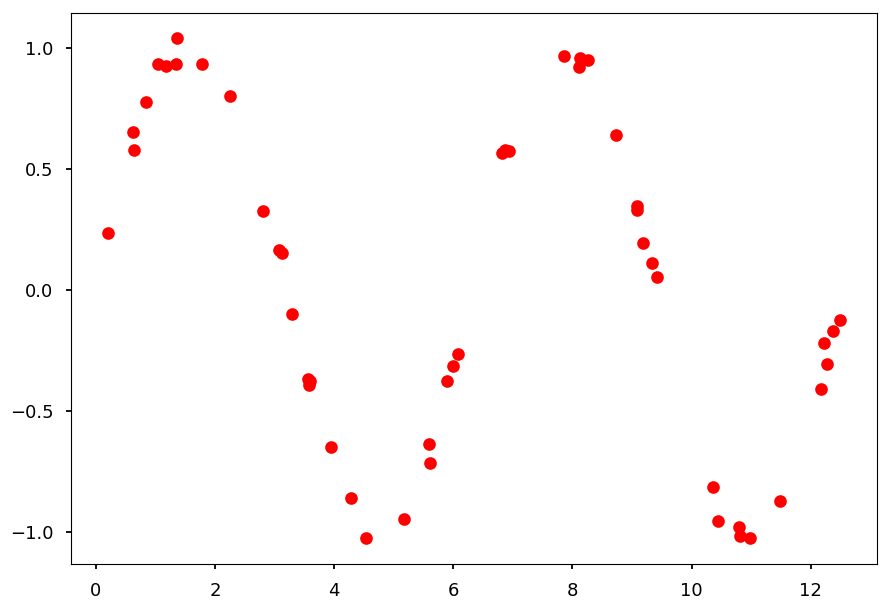

In [55]:
data_size = 50

# generate and sort *data_size* numbers from 0 to 4pi 
x_train = 4 * np.pi * np.sort(np.random.rand(data_size, 1), axis=0)

# let's fit to sine  
y_train = np.sin(x_train).ravel()

# add some noise to the data
y_train = np.array([np.random.normal(y, 0.05) for y in y_train])

plt.plot(x_train, y_train, 'ro');

### Make a fit

* In general, one should do cross-validation to determine the best *k*

* We will skip this part during the lecture (feel free to check this at home though!)

* Let's just check how kNN fit works for a few different values of *k*

### Comment on `numpy.newaxis`

In [56]:
# let's create a 1D numpy array
D1 = np.array([1, 2, 3, 4])

print(D1)

[1 2 3 4]


In [57]:
# we can easily add another dimension using numpy.newaxis
D2 = D1[:, np.newaxis]

print(D2)

[[1]
 [2]
 [3]
 [4]]


### And back to the task

* We use kNN regressor from `scikit-learn` (from intro: *What I really do...*)

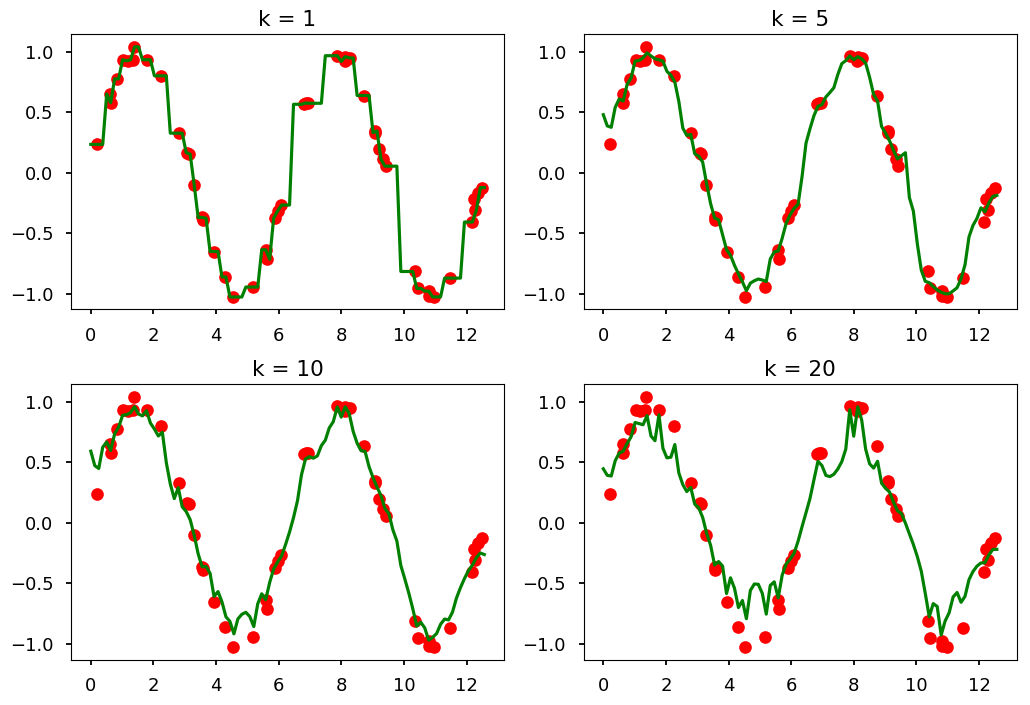

In [58]:
from sklearn.neighbors import KNeighborsRegressor

# first we need test sample
x_test = np.linspace(0, 4*np.pi, 100)[:, np.newaxis]

for i, k in enumerate((1, 5, 10, 20)):
  # weights=distance - weight using distances
  knn = KNeighborsRegressor(k, weights='distance')
  
  # calculate y_test for all points in x_test
  y_test = knn.fit(x_train, y_train).predict(x_test)
  
  plt.subplot(2, 2, i + 1)

  plt.title("k = {}".format(k))
  
  plt.plot(x_train, y_train, 'ro', x_test, y_test, 'g');
  
plt.tight_layout()

## Summary

* We have learned first ML algorithm - k-Nearest Neighbors

* It has some pros:

    * easy to understand and implement

    * no time needed for training - may be used for initial analysis before one reaches for some *heavier* tool
    
    * solves nonlinear problems 
    
    * limited number of hyperparameters
    
    * no parameters!
    
    * *at the end of this lecture we will deal with tens of hyperparameters and thousands of parameters*

* Although cons make it hard to use in practice

    * training data must be kept for the whole time (so called **lazy training**)
    
        * imagine having GB of training samples and you want to make mobile app
        
        * other algorithms allows to discard training samples once the model is trained (**eager learning**) - usually it means long training process but super fast classification (which is what we really want)
  
    * distance-comparing is not suitable for all data - a picture of a cat on a blue background (e.g. sky) can be close to a ship on a sea (because background pixels vote too)

        * e.g. for [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) (60k pictures, 10 classes, more about that later) vanilla kNN get less than 40% accuracy

      * still better than random guessing (10%), but convolutional neural networks get >95%

* Still, we have learned from kNN a few important things:

    * Data is important (both size and quality)
    
    * Sometimes data requires preprocessing
    
    * Wrong choice of hyperparameters may lead to under- or over-fitting
        
        * Use validation samples to tune the model
        
        * And **DO NOT** touch test samples until you are done!    